In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from skimage import data, color
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
from tensorflow.keras.models import load_model

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#loading microstructures and masks

path = 'C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\grain boundaries train val\\'
inputs = []
masks=[]
val_images = []
val_masks = []
img_resize = (256,256)
for image in os.listdir(path+'images'): #train images
    img = cv2.imread(path+'images\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    inputs.append(img)
    
inputs = np.array(inputs)
inputs = inputs/255
inputs = np.expand_dims(inputs, axis=-1)

for image in os.listdir(path+'masks'):# train masks
    img = cv2.imread(path+'masks\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    masks.append(img)
    
masks = np.array(masks)
masks = masks/255
masks = np.expand_dims(masks, axis=-1)

for image in os.listdir(path+'reserve_images'): #validation images
    img = cv2.imread(path+'reserve_images\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    val_images.append(img)
    
val_images = np.array(val_images)  
val_images = val_images/255
val_images = np.expand_dims(val_images, axis=-1)

for image in os.listdir(path+'reserve_masks'): #validation masks
    img = cv2.imread(path+'reserve_masks\\'+image, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
    val_masks.append(img)
    
val_masks = np.array(val_masks)  
val_masks = val_masks/255
val_masks = np.expand_dims(val_masks, axis=-1)

In [3]:
val_masks.shape

(15, 256, 256, 1)

In [4]:
#showing sample training image
cv2.imshow('sample input', inputs[4])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Dropout
from tensorflow.keras.optimizers import SGD

In [6]:
def down_block(x, filters, kernel_size=(2,2), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), strides=(2,2))(c)
    drop1 = Dropout(0.2)
    p = drop1(inputs=p, training=True)
    return c, p

def up_block(x, skip, filters, kernel_size=(2,2), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    drop2 = Dropout(0.2)
    concat = drop2(inputs=concat, training=True)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(2,2), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [7]:
def UNet():
    f = 6
    inputs = keras.layers.Input((256, 256, 1))
    
    '''
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2]) 
    c4, p4 = down_block(p3, f[3]) 
    c5, p5 = down_block(p4, f[4])
    
    bn = bottleneck(p5, f[5])
    
    u1 = up_block(bn, c5, f[4]) 
    u2 = up_block(u1, c4, f[3]) 
    u3 = up_block(u2, c3, f[2]) 
    u4 = up_block(u3, c2, f[1]) 
    u5 = up_block(u4, c1, f[0]) 

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u5)
    '''
    
    p0 = inputs
    c1, p1 = down_block(p0, 16) 
    c2, p2 = down_block(p1, 32) 
    c3, p3 = down_block(p2, 64) 
    c4, p4 = down_block(p3, 128) 
    c5, p5 = down_block(p4, 256)
    c6, p6 = down_block(p5, 512)
    c7, p7 = down_block(p6, 1024)
    
    bn = bottleneck(p7, 2048)
    
    u1 = up_block(bn, c7, 1024) 
    u2 = up_block(u1, c6, 512) 
    u3 = up_block(u2, c5, 256) 
    u4 = up_block(u3, c4, 128) 
    u5 = up_block(u4, c3, 64) 
    u6 = up_block(u5, c2, 32) 
    u7 = up_block(u6, c1, 16) 

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u7)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
#model = UNet()
#model.compile(optimizer=SGD(learning_rate=0.5,nesterov=True), loss="mse")
model = load_model('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\bad_ovf_interesting_SGD_nesterov_graph.h5')
model.summary()
#tf.keras.backend.clear_session()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 16) 80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 16) 1040        conv2d_31[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_32[0][0]                  
____________________________________________________________________________________________

In [9]:
#log_directory = 'logs\\fit'

In [10]:
from tensorflow.keras.callbacks import EarlyStopping #, TensorBoard
early_stop = EarlyStopping(monitor='val_loss',patience=500)
'''board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)'''

"board = TensorBoard(log_dir=log_directory,histogram_freq=1,\n    write_graph=True,\n    write_images=True,\n    update_freq='epoch',\n    profile_batch=2,\n    embeddings_freq=1)"

In [12]:
model.fit(inputs, masks, validation_data =[val_images, val_masks], epochs=3000, callbacks =[early_stop])

Train on 5 samples, validate on 15 samples
Epoch 1/3000
5/5 [==============================] - 1s 103ms/sample - loss: nan - val_loss: nan
Epoch 2/3000
5/5 [==============================] - 1s 101ms/sample - loss: nan - val_loss: nan
Epoch 3/3000
5/5 [==============================] - 1s 101ms/sample - loss: nan - val_loss: nan
Epoch 4/3000
5/5 [==============================] - 1s 102ms/sample - loss: nan - val_loss: nan
Epoch 5/3000
5/5 [==============================] - 1s 101ms/sample - loss: nan - val_loss: nan
Epoch 6/3000
5/5 [==============================] - 1s 101ms/sample - loss: nan - val_loss: nan
Epoch 7/3000
5/5 [==============================] - 1s 102ms/sample - loss: nan - val_loss: nan
Epoch 8/3000
5/5 [==============================] - 0s 20ms/sample


KeyboardInterrupt: 

In [13]:
losses = pd.DataFrame(model.history.history)

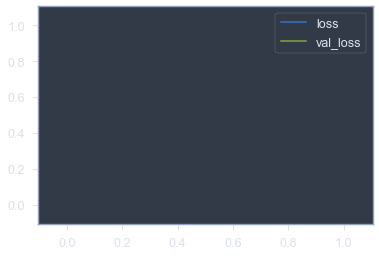

In [14]:
losses[['loss','val_loss']].plot()

In [15]:
#loading training set
passed_images = inputs[:5]

In [16]:
#passing training set into network
constructed_masks = model.predict(passed_images)

In [17]:
#predicted masks for training set
n=0
#cv2.imshow('original image', cv2.resize(np.squeeze(inputs[n]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.imshow('original image', np.squeeze(inputs[n]))
cv2.waitKey(0)
cv2.destroyAllWindows()

#cv2.imshow('real mask', cv2.resize(np.squeeze(masks[n]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.imshow('real mask', np.squeeze(masks[n]))
cv2.waitKey(0)
cv2.destroyAllWindows()

#cv2.imshow('constructed', cv2.resize(np.squeeze(constructed_masks[n]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.imshow('constructed', np.squeeze(constructed_masks[n]))
cv2.waitKey(0)
cv2.destroyAllWindows()

Testing Individual Validation Image

In [33]:
#edit to change image being evaluated
test_path = 'C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\grain boundaries train val\\val_images\\21_H1_Long_1000x.jpg'

In [36]:
test =[]
img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, img_resize, interpolation = cv2.INTER_AREA)
test.append(img)

test = np.array(test)
test = test/255
test = np.expand_dims(test, axis=-1)

In [37]:
img.shape

(256, 256)

In [39]:
#show original test image

#cv2.imshow('original image', cv2.resize(np.squeeze(test[0]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.imshow('original image', np.squeeze(test[0]))
cv2.waitKey(0)
cv2.destroyAllWindows()

#show predicted test mask before upscaling
prediction = model.predict(test)
#cv2.imshow('predicted mask', cv2.resize(np.squeeze(prediction[0]), (1280,960), interpolation = cv2.INTER_CUBIC))
cv2.imshow('predicted mask', np.squeeze(prediction[0]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
#undo normalization and squeeze to 2by2 array
prediction = np.squeeze(prediction[0]) * 255

In [ ]:
#needed for imwrite to work
prediction = prediction.astype('uint8')

In [ ]:
prediction = cv2.resize(prediction, (1280, 960), interpolation = cv2.INTER_CUBIC)

cv2.imshow('predicted mask', prediction[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

#uncomment below and change name to save file
#cv2.imwrite('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\constructed masks\\new1.jpg', prediction)

In [26]:
#saving the brain
model.save('C:\\Users\\kevin\\Desktop\\CMS\\Steel Image\\bad_ovf_interesting_SGD_nesterov_graph.h5')